# Disease Propagation - Monte Carlo Experiment

In this experiment I'll demonsrate the predictive prowess of the Monte Carlo method. With Covid-19 in the rear view mirror, it felt relevant doing an experiment which simulates the propagation of a disease in a population.

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

STATUS_VULNERABLE = 'vulnerable'
STATUS_INFECTED = 'infected'
STATUS_RECOVERED = 'recovered'
STATUS_DEAD = 'dead'

### Part 1 - Main experiment flow


A way to represent a spread of disease is to model each stage a person can have as a "state" and have fixed estimated probabilities to transfer from each stage to another. A Markov Model can make sense here. 

In [ ]:
class Person:
    def __init__(self, status=STATUS_VULNERABLE, days_of_status=0):
        self._status = status
        self._days_of_status = days_of_status

    @property
    def status(self):
      return self._status
    
    @property
    def days_of_status(self):
      return self._days_of_status

    def set_status(self, x):
      self._status = x

    def set_days_of_status(self, x):
      self._days_of_status = x

The simulation runs for a year where:
- Each infected person has 7% percent chance to infect a single person and 4% chance to infect two people.

- After 9 days, each infected person has 1% chance to die and 30% chance to recover every day.

- Recovered people cannot get sick again.

In [ ]:
def simulation(num_people):

    # essentially queues to move people around the states
    person_types = dict()
    person_types['vulnerables'] = [Person()]*(num_people - 1)
    person_types['infected'] = [Person()]
    person_types['recovered'] = list()
    person_types['dead'] = list()

    # track amount of people of each states
    person_trackers = dict()
    person_trackers['vulnerables'] = [num_people - 1]
    person_trackers['infected'] = [1]
    person_trackers['recovered'] = [0]
    person_trackers['dead'] = [0]

    # starting on day 1, day 0 is the starting data in the lists
    curr_day = 1

    while curr_day < 365:
        amount_of_people_recovered_today = 0
        amount_of_people_died_today = 0
        amount_of_people_infected_today = 0

        # each day, any change has something to do with the infected people
        for infected_person in person_types['infected']:   
            if curr_day - infected_person.days_of_status >= 10:
                not_sick_anymore_prob = random.randint(1, 100)
                if not_sick_anymore_prob == 1:
                    amount_of_people_died_today += 1
                    continue
                elif 2 <= not_sick_anymore_prob <= 31:
                    amount_of_people_recovered_today += 1
                    continue

            # if the infected is still infected, he/she could infect others
            infection_prob = random.randint(1, 100)
            if infection_prob <= 4:
                amount_of_people_infected_today += 2
            elif 5 <= infection_prob <= 11:
                amount_of_people_infected_today += 1

        # update trackers for status changes today
        if amount_of_people_infected_today > 0:
            for _ in range(amount_of_people_infected_today):
                if len(person_types['vulnerables']) > 0:
                    infectee = person_types['vulnerables'].pop()
                    infectee.set_days_of_status(curr_day)
                    person_types['infected'].append(infectee)

        if amount_of_people_recovered_today > 0:
            for _ in range(amount_of_people_recovered_today):
                if len(person_types['infected']) > 0:
                    recoveree = person_types['infected'].pop()
                    person_types['recovered'].append(recoveree)

        if amount_of_people_died_today > 0:
            for _ in range(amount_of_people_died_today):
                if len(person_types['infected']) > 0:
                    died = person_types['infected'].pop()
                    person_types['dead'].append(died)

        # append count to the trackers to keep continuous information of the count in each status group
        person_trackers['vulnerables'].append(len(person_types['vulnerables']))
        person_trackers['infected'].append(len(person_types['infected']))
        person_trackers['recovered'].append((len(person_types['recovered'])))
        person_trackers['dead'].append(len(person_types['dead']))

        curr_day += 1

    return person_trackers

In [96]:
def plot_simulation(num_people):
    person_trackers = simulation(num_people)

    # show first 10 days
    print(pd.DataFrame(person_trackers).head(10))      
    print('\n\n')

    # plot amount of vulnerable people for a year
    df = pd.DataFrame(person_trackers.pop('vulnerables'))
    plt.figure(figsize=(7,12))
    df.plot.line()
    plt.title('Virus Propagation Example')
    plt.xlabel('Days')
    plt.ylabel('Amount of Vulnerable People')
    plt.show()

Now we can plot a single simulation of the disease propagation

   vulnerables  infected  recovered  dead
0           99         1          0     0
1           99         1          0     0
2           99         1          0     0
3           97         3          0     0
4           97         3          0     0
5           97         3          0     0
6           95         5          0     0
7           95         5          0     0
8           94         6          0     0
9           92         8          0     0





<Figure size 504x864 with 0 Axes>

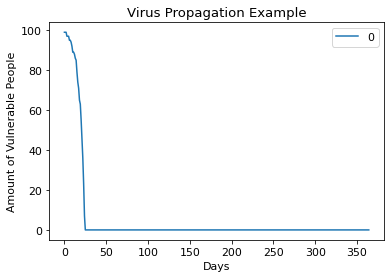

In [97]:
plot_simulation(100)

### Part 2 - Monte Carlo 

Next, let's check out interesting statistics and predictions that can be derived from running the experiment 100 times.

The power of using Monte Carlo is that we have the ability ot run X different experiments where the variables derive from the same distribution, therefore we have created a dataset of 100 random samples on which we can draw conclusions and prediction boundaries 

In [ ]:
# initialize variables
NUM_EXPERIMENTS = 100
NUM_PEOPLE = 10000
total_dead_on_day_100 = 0
total_recovered_on_day_100 = 0
percentage_infected_today_or_before = [x * 0 for x in range(NUM_EXPERIMENTS + 1)]
daily_average_infections = [x * 0 for x in range(NUM_EXPERIMENTS + 1)]

# helper functions
def infected_today_or_before(vulnerables_data_old, vulnerables_data_new, num_people):
    vulnerables_data_old = [(num_people - x) / num_people for x in vulnerables_data_old]
    vulnerables_data_new = [(num_people - x) / num_people for x in vulnerables_data_new]
    return [x + y for x, y in zip(vulnerables_data_old, vulnerables_data_new)]

def daily_infection_percentage_add(infected_data_old, infected_data_new, num_people):
    infected_data_old = [x / num_people for x in infected_data_old]
    infected_data_new = [x / num_people for x in infected_data_new]
    return [x + y for x, y in zip(infected_data_old, infected_data_new)]

In [ ]:
# run simulation once for initial variables
initial_person_trackers = simulation(NUM_PEOPLE)


# Run simulation 99 more times
for sim in range(1, NUM_EXPERIMENTS+1):
  if (sim) % 10 == 0: 
    print(f'currently running simulation number {sim} / 100')
  person_trackers = simulation(NUM_PEOPLE)

  percentage_infected_today_or_before = infected_today_or_before(initial_person_trackers['vulnerables'], 
                                                                 person_trackers['vulnerables'], 
                                                                 NUM_PEOPLE)
  daily_average_infections = daily_infection_percentage_add(initial_person_trackers['infected'], 
                                                            person_trackers['infected'], 
                                                            NUM_PEOPLE)
  total_dead_on_day_100 += person_trackers['dead'][-1]
  total_recovered_on_day_100 += person_trackers['recovered'][-1]

currently running simulation number 10 / 100
currently running simulation number 20 / 100
currently running simulation number 30 / 100
currently running simulation number 40 / 100
currently running simulation number 50 / 100
currently running simulation number 60 / 100
currently running simulation number 70 / 100
currently running simulation number 80 / 100
currently running simulation number 90 / 100
currently running simulation number 100 / 100


### Part 3 - Draw significant conclusions

Now that we have 100 samples, we can look at statistics and metrics to draw conclusions from. 


---


Due to the Central Limit Theorom, the averages of these experiments have a normal distribution, meaning that running 100 experiments again won't change the results in a major way, because the results will most likely have a result around the sample mean.

In conclusion: we can calculate expected values of a pandemic outcome!

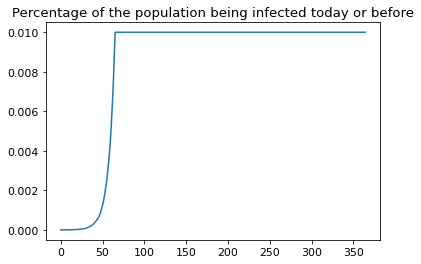

In [90]:
# Percentage of the population being infected today or before
prec_infected_today_before = [x / NUM_EXPERIMENTS for x in percentage_infected_today_or_before]
plt.plot(prec_infected_today_before)
plt.title('Percentage of the population being infected today or before')
plt.show()

In [92]:
# Total percentage of dead vs. recovered people in the population after a year
res = total_dead_on_day_100 / total_recovered_on_day_100
print(f'{round(res*100, 2)}%')

3.31%


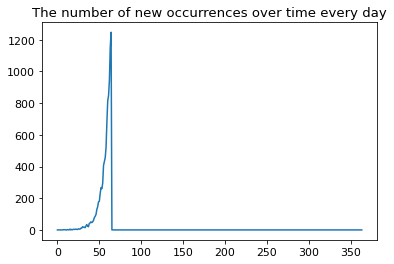

In [93]:
# Used the last of the 100 iterations in calculating new occurrences
new_occurences = [j - i for i, j in zip(person_trackers['infected'][:-1], 
                                        person_trackers['infected'][1:])]
for i in range(len(new_occurences)):
    if new_occurences[i] < 0:
        new_occurences[i] = 0

plt.plot(new_occurences)
plt.title('The number of new occurrences over time every day')
plt.show()

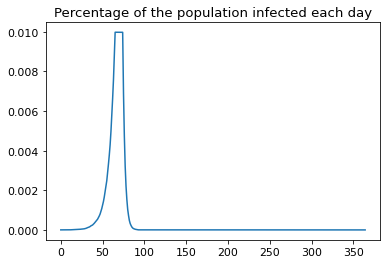

In [95]:
# Percentage of the population infected each day
prec_infected_each_day = [x / NUM_EXPERIMENTS for x in daily_average_infections]
plt.plot(prec_infected_each_day)
plt.title('Percentage of the population infected each day')
plt.show()

#### To conclude: Monte Carlo is a powerful technique we can use to calculate expected values of a mathematical process which has a randomness factor.